## 1. Introduction


There were 3.8 million 30 day all cause adult hospital readmissions, with a 14% readmission rate and an average readmission cost of $15,200, in 2018, according to the [Agency for Healthcare Research and Quality (AHRQ)](https://www.hcup-us.ahrq.gov/reports/statbriefs/sb278-Conditions-Frequent-Readmissions-By-Payer-2018.jsp). For patients, high readmissions not only increase their cost, but also is a sign of poor quality of health service they received. For hospitals, high readmissions not only increase the administrative burden, but also lead to penalty from [Hospital Readmissions Reduction Program (HRRP)](https://www.cms.gov/Medicare/Medicare-Fee-for-Service-Payment/AcuteInpatientPPS/Readmissions-Reduction-Program). Therefore, reducing hospital readmissions has long been a health policy goal to improve health care quality.

## 2. The business task

As data analysts, we are going to find out how readmission rates are associated with: age of patients, race/ethnicity of patients, payer type, county, population to LTC (Long Term Care) type facility ratio, and population to FDR (First Tier, Downstream, and Related Entities defined by CMS) type facility ratio, and then provide recommendations to lower the readmission rate.

## 3. Prepare
### 3.1 Data used

This project will analyze 3 datasets, we will focus on 1 main dataset and join the other 2 datasets for additional information.

[**California All-Cause Unplanned 30-Day Inpatient Readmission Rates**](https://data.chhs.ca.gov/dataset/all-cause-unplanned-30-day-hospital-readmission-rate-california): It's the main dataset, which contains the statewide number and (unadjusted) rate for all-cause, unplanned, 30-day inpatient readmissions in California hospitals from 2011 to 2020 (contains first three quarters for Year 2015). Data are categorized by age, sex, race/ethnicity, expected payer and county. It has a list of fields:
- `Year`: Year of discharge
- `Strata`: Includes Age, Sex, Race-Ethinicity, and Expected Payer
- `Strata Name`: Detail information of each stratum
- `County`: County of patient residence
- `Total Admits (ICD-9)`: Number of total admissions in California acute care hospitals
- `30-day Readmits (ICD-9)`: Number of all-cause unplanned 30-day readmissions in California acute care hospitals (ICD-9)
- `30-day Readmission Rate (ICD-9)`: Statewide all-cause unplanned 30-day hospital readmission rate (unadjusted, ICD-9)
- `Total Admits (ICD-10)`: Number of total admissions in California acute care hospitals (ICD-10)
- `30-day Readmits (ICD-10)`: Number of all-cause unplanned 30-day readmissions in California acute care hospitals(ICD-10)
- `30-day Readmission Rate (ICD-10)`: Statewide all-cause unplanned 30-day hospital readmission rate (unadjusted)(ICD-10)

[**California Licensed and Certified Healthcare Facility Listing**](https://data.chhs.ca.gov/dataset/healthcare-facility-locations): This dataset was recently updated in December, 2022. It includes California healthcare facilities that are operational and have a current license issued by the California Department of Public Health (CDPH) and/or a current U.S. Department of Health and Human Services’ Centers for Medicare and Medicaid Services (CMS) certification. It has 59 fields, we only need 4 of them:
- `FACID`: Identifier of facility
- `LTC`: LTC type of facility, with 3 values: NON-LTC (Not Long-Term Care), LTC (Long-Term Care), and OTHER. Will rename it to `LTC_Type` to avoid confusion.
- `FAC_FDR`: FDR (First Tier, Downstream, and Related Entities defined by CMS) entity type of facility, each FDR facility belongs either LTC, NON-LTC or OTHER facility. Will rename it to `FDR_Type`.
- `COUNTY_NAME`: County of facility. It can be joined with the main dataset's `County`.


[**California County Population 2020-2021**](https://www.census.gov/data/tables/time-series/demo/popest/2020s-counties-detail.html): This dataset includes county population of California in 2020-2021. The Excel file has 4 columns with long headers, we only need 2 of them:
- County Name: It can be joined with the main dataset's `County`, will rename it to `County`.
- April 1, 2020 Population Estimates: The populatoin of county, will rename it to `Population`


### 3.2 Data stored
They are stored in an AWS S3 bucket 'hospital-readmission-rate'.

### 3.3 Importing the data

**30 Day Readmission Rates**

In [638]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px
import requests
import json
from scipy import stats

# set seaborn theme
custom_params = {"axes.spines.right": False, "axes.spines.top": False, 
                 "figure.dpi":100, 'savefig.dpi':100}
sns.set_theme(style="ticks", rc=custom_params)
%config InlineBackend.figure_format = "retina"

# settings to display all columns/rows
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000 
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 80
warnings.filterwarnings(action="ignore")

# read the file of all cause unplanned 30 day hospital readmission rates
bucket = 'hospital-readmission-rate'
file_readmission = 'california-hospital-readmission-rate-2011-2020.csv'
data_readmission = pd.read_csv(f's3://{bucket}/{file_readmission}')
# check first 5 rows
data_readmission.head()

,Year,Strata,Strata Name,County,Total Admits (ICD-9),30-day Readmits (ICD-9),30-day Readmission Rate (ICD-9),Total Admits (ICD-10),30-day Readmits (ICD-10),30-day Readmission Rate (ICD-10)
0,2011,Overall,Overall,State,1948641.0,272268.0,14%,NaN,NaN,NaN
1,2011,Age,18 to 44 years,State,326070.0,36855.0,11.30%,NaN,NaN,NaN
2,2011,Age,45 to 64 years,State,659801.0,90891.0,13.80%,NaN,NaN,NaN
3,2011,Age,65 years and above,State,962771.0,144522.0,15%,NaN,NaN,NaN
4,2011,Sex,Male,State,901776.0,132417.0,14.70%,NaN,NaN,NaN


In [180]:
# check last 5 rows
data_readmission.tail()

,Year,Strata,Strata Name,County,Total Admits (ICD-9),30-day Readmits (ICD-9),30-day Readmission Rate (ICD-9),Total Admits (ICD-10),30-day Readmits (ICD-10),30-day Readmission Rate (ICD-10)
748,2020,Overall,Overall,Tulare,NaN,NaN,NaN,18786,2653,14.12%
749,2020,Overall,Overall,Tuolumne,NaN,NaN,NaN,3304,474,14.35%
750,2020,Overall,Overall,Ventura,NaN,NaN,NaN,34820,4945,14.20%
751,2020,Overall,Overall,Yolo,NaN,NaN,NaN,6945,976,14.05%
752,2020,Overall,Overall,Yuba,NaN,NaN,NaN,4513,712,15.78%


In [181]:
# check data types and missing data
data_readmission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Year                              753 non-null    int64  
 1   Strata                            753 non-null    object 
 2   Strata Name                       753 non-null    object 
 3   County                            753 non-null    object 
 4   Total Admits (ICD-9)              375 non-null    float64
 5   30-day Readmits (ICD-9)           375 non-null    float64
 6   30-day Readmission Rate (ICD-9)   375 non-null    object 
 7   Total Admits (ICD-10)             378 non-null    object 
 8   30-day Readmits (ICD-10)          377 non-null    object 
 9   30-day Readmission Rate (ICD-10)  377 non-null    object 
dtypes: float64(2), int64(1), object(7)
memory usage: 59.0+ KB


What we can learn:
- The dataset has 753 records and 10 field. 
- Some fields contain Nulls, as readmission rates were recorded with ICD-9 in 2011-2015, after that, they were recorded with ICD-10. We will need to combine them.
- Need to convert # of readmissions related fields from `float` to `int`.
- Need to convert 4 readmission related fields from `object` to `float`. 

**Licensed and Certified Healthcare Facility Listing**

In [538]:
# read the file of Licensed and Certified Healthcare Facility Listing
file_ltc = 'california-licensed-healthcare-facility-locations.xlsx'
data_ltc = pd.read_excel(f's3://{bucket}/{file_ltc}')
# get its subset with needed 4 fields
data_ltc = data_ltc[['FACID', 'FAC_FDR', 'LTC', 'COUNTY_NAME']]
data_ltc.head()

,FACID,FAC_FDR,LTC,COUNTY_NAME
0,010000001,SKILLED NURSING FACILITY,LTC,SONOMA
1,010000003,SKILLED NURSING FACILITY,LTC,SONOMA
2,010000004,SKILLED NURSING FACILITY,LTC,DEL NORTE
3,010000005,SKILLED NURSING FACILITY,LTC,SONOMA
4,010000024,SKILLED NURSING FACILITY,LTC,HUMBOLDT


In [539]:
data_ltc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14820 entries, 0 to 14819
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   FACID        14820 non-null  object
 1   FAC_FDR      14820 non-null  object
 2   LTC          14820 non-null  object
 3   COUNTY_NAME  14820 non-null  object
dtypes: object(4)
memory usage: 463.2+ KB


This dataset has no missing values, but the `COUNTY_NAME` are all uppercase values. We will need to convert it to match with the main dataset.

**California County Population**

In [373]:
file_population = 'california-county-population-2020.xlsx'
data_ltc = pd.read_excel(f's3://{bucket}/{file_population}')
data_population.head()

,table with row headers in column A and column headers in rows 3 through 4 (leading dots indicate sub-parts),Unnamed: 1,Unnamed: 2,Unnamed: 3
0,Annual Estimates of the Resident Population for Counties in California: Apri...,NaN,NaN,NaN
1,Geographic Area,"April 1, 2020 Estimates Base",Population Estimate (as of July 1),NaN
2,NaN,NaN,2020,2021.0
3,California,39538223,39499738,39237836.0
4,".Alameda County, California",1682353,1679844,1648556.0


We need to modify it to make it readable:

In [374]:
data_population = data_population.iloc[3:, :2]
data_population.columns = ['County', 'Population']
data_population.head()

,County,Population
3,California,39538223
4,".Alameda County, California",1682353
5,".Alpine County, California",1204
6,".Amador County, California",40474
7,".Butte County, California",211632


In [375]:
data_population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 3 to 66
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   County      64 non-null     object
 1   Population  59 non-null     object
dtypes: object(2)
memory usage: 1.1+ KB


We will need to do some data cleaning before merging it with the readmission dataset:
- Need to convert Population from `float` type to `int`
- Need to remove unexpected string/spaces in the county names

## 4. Process

We need to clean and format these datasets, and then left join the licensed facility dataset to the readmission rates dataset.
Before that, let's get the county list of the readmission rates dataset.

### 4.1 Check unknown counties

In [376]:
# check if each county has 10 years of records
data_readmission['County'].value_counts().rename_axis('County').reset_index(name='counts')

,county,counts
0,State,172
1,Alameda,10
2,Plumas,10
3,Riverside,10
4,Sacramento,10
5,San Benito,10
6,San Bernardino,10
7,San Diego,10
8,San Francisco,10
9,San Joaquin,10


There is one "Unknown County", but all the other counties have 10 records (201-2020). Let's check if it's from "State".

In [377]:
# get the record of unknown county
data_readmission[data_readmission['County'] == 'Unknown County']

,Year,Strata,Strata Name,County,Total Admits (ICD-9),30-day Readmits (ICD-9),30-day Readmission Rate (ICD-9),Total Admits (ICD-10),30-day Readmits (ICD-10),30-day Readmission Rate (ICD-10)
618,2019,Overall,Overall,Unknown County,NaN,NaN,NaN,374,59,15.78%


In [378]:
# get 2019 record of "State"
data_readmission[(data_readmission['Year'] == 2019) 
                 & (data_readmission['Strata'] == 'Overall') 
                 &(data_readmission['County'] == 'State')]

,Year,Strata,Strata Name,County,Total Admits (ICD-9),30-day Readmits (ICD-9),30-day Readmission Rate (ICD-9),Total Admits (ICD-10),30-day Readmits (ICD-10),30-day Readmission Rate (ICD-10)
600,2019,Overall,Overall,State,NaN,NaN,NaN,1866911,277886,14.88%


Obviously, "Unknown County" doesn't belong to state or any county, let's remove it.

### 4.2 Data cleaning and merging

In [653]:
def clean_readmission(data):
    """Method for cleaning the readmission rates dataset 
    
    Args:
        data: the readmission rates dataset
    Returns:
        a clean dataset with ICD-9/ICD-10 records combined
    """
    df = data.copy()
    # remove white spaces from field names
    df.columns = df.columns.str.strip()
    # remove "Unknown County" record
    df = df[df['County'] != 'Unknown County']
    
    # create new fields to get data either recorded in ICD-9 or in ICD-10
    df['Admissions'] = df[['Total Admits (ICD-9)', 'Total Admits (ICD-10)']].bfill(axis=1).iloc[:, 0]
    df['Readmissions'] = df[['30-day Readmits (ICD-9)', '30-day Readmits (ICD-10)']].bfill(axis=1).iloc[:, 0]
    df['Readmission Rate Percentage'] = df[['30-day Readmission Rate (ICD-9)', 
                                            '30-day Readmission Rate (ICD-10)']].bfill(axis=1).iloc[:, 0]
    # drop unnecessary fields
    df.drop(columns=['Total Admits (ICD-9)', 'Total Admits (ICD-10)',
                     '30-day Readmits (ICD-9)', '30-day Readmits (ICD-10)',
                     '30-day Readmission Rate (ICD-9)', '30-day Readmission Rate (ICD-10)'], inplace=True)
    # remove duplicates
    df.drop_duplicates(inplace=True)
    # fill missing values
    df.fillna(0, inplace=True)
    # convert to correct data types
    df['Admissions'] = df['Admissions'].replace(',', '', regex=True).astype(int)
    df['Readmissions'] = df['Readmissions'].replace(',', '', regex=True).astype(int)
    df['Readmission Rate Percentage'] = df['Readmission Rate Percentage']\
                                        .replace('%', '', regex=True).astype(float)

    return df

def clean_ltc(data):
    """Method for cleaning the licensed facility dataset 
    
    Args:
        data: the licensed facility dataset
    Returns:
        a clean dataset that are ready to be joined with the readmission rates dataset
    """
    df = data.copy()
    # convert uppercase county names and FDR type names to be capitalized
    df['COUNTY_NAME'] = df['COUNTY_NAME'].str.title()
    df['FAC_FDR'] = df['FAC_FDR'].str.title()
    # rename county field
    df.rename(columns={'COUNTY_NAME': 'County', 'FACID': 'Facility_ID', 'LTC': 'LTC_Type', 'FAC_FDR': 'FDR_Type'},
              inplace=True)
    df.drop_duplicates(inplace=True)
    
    return df

def clean_population(data):
    """Method for cleaning the county population dataset 
    
    Args:
        data: the county population dataset
    Returns:
        a clean dataset that are ready to be joined with the readmission rates dataset
    """
    df = data.copy()
    # remove "." and " County, California" from county name
    df['County'] = df['County'].str.replace('\.| County, California', '', regex=True)
    # replace "California" with "State" in order to match with readmission rate dataset
    df['County'].replace('California', 'State', inplace=True)
    # return valid records
    df = df.query("County.notna() & Population.notna()")
    df['Population'] = df['Population'].astype(int)
    df.drop_duplicates(inplace=True)
    
    return df

# cleaning the 3 datasets
df_readmission = clean_readmission(data_readmission)
df_ltc = clean_ltc(data_ltc)
df_population = clean_population(data_population)

# merging datasets
df_all = df_readmission.merge(df_ltc, how='left', on='County')
df_all = df_all.merge(df_population, how='left', on='County')

# randomly check a few records
df_all.sample(5, random_state=1)

,Year,Strata,Strata Name,County,Admissions,Readmissions,Readmission Rate Percentage,Facility_ID,FDR_Type,LTC_Type,Population
8505,2011,Overall,Overall,Marin,12210,1414,11.60,630021268,Hospice,NON-LTC,262321
87705,2016,Overall,Overall,Santa Clara,68322,9691,14.18,630016842,Primary Care Clinic,NON-LTC,1936259
112661,2018,Overall,Overall,Nevada,5779,799,13.83,100001759,Hospice,NON-LTC,102241
116215,2018,Overall,Overall,San Diego,153864,21665,14.08,630026197,Primary Care Clinic,NON-LTC,3298634
8715,2011,Overall,Overall,Monterey,18178,1973,10.90,630012202,Home Health Agency,NON-LTC,439035


In [380]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148372 entries, 0 to 148371
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Year                         148372 non-null  int64  
 1   Strata                       148372 non-null  object 
 2   Strata Name                  148372 non-null  object 
 3   County                       148372 non-null  object 
 4   Admissions                   148372 non-null  int64  
 5   Readmissions                 148372 non-null  int64  
 6   Readmission Rate Percentage  148372 non-null  float64
 7   Facility_ID                  148190 non-null  object 
 8   FDR_Type                     148190 non-null  object 
 9   LTC_Type                     148190 non-null  object 
 10  Population                   148372 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 13.6+ MB


There are 182 records that contain Nulls from fields of licensed facility dataset, which means some counties that don't have licensed facility. Let's check what those counties are.

In [382]:
df_all.loc[pd.isnull(df_all).any(axis=1), 'County'].value_counts()

State     172
Alpine     10
Name: County, dtype: int64

"State" is from statewide records of readmissions, we can get statewide facilities by summing up all counties' data. "Alpine" is the only county that without matched facilities, for now let's just leave it as it is.

Next, let's start Exploratory Data Analysis (EDA).

## 5. Analyze

### 5.1 Statewide
#### Over time

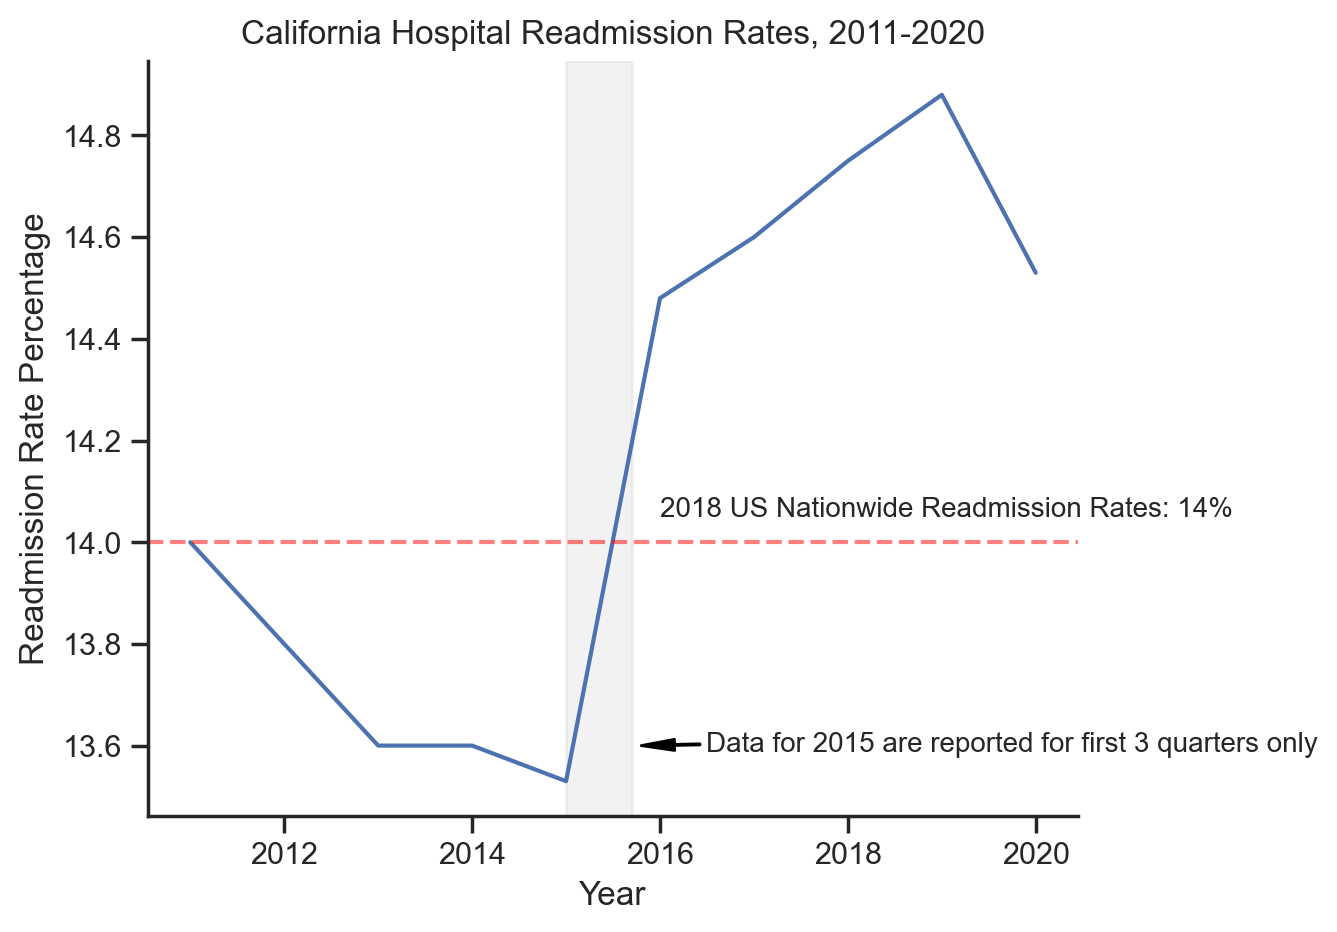

In [388]:
# plot statewide line chart
def lineplot_state_rate(data):
    ax = sns.lineplot(data=data, x="Year", y="Readmission Rate Percentage")
    ax.axhline(y=14, color='red', alpha=0.5, linestyle='dashed')
    ax.text(2016, 14.05, "2018 US Nationwide Readmission Rates: 14%", fontsize=10)
    ax.axvspan(2015, 2015.7, alpha=0.1, color='gray')
    ax.annotate('Data for 2015 are reported for first 3 quarters only', 
                xy=(2015.8, 13.6),
                xycoords='data',
                xytext=(0.6, 0.085), 
                textcoords='axes fraction',
                fontsize=10,
                arrowprops=dict(color='black', width=0.4, headwidth=4))
    ax.set(title='California Hospital Readmission Rates, 2011-2020')
    plt.show()

# get statewide readmissions
df_state_overall = df_readmission.query("Strata == 'Overall' & County == 'State'")
plt.figure(figsize=(6, 5))
lineplot_state_rate(df_state_overall)

We cannot compare ICD-9 (2011-2014) and ICD-10 (Oct 2015 - 2020), so it's hard to get a solid conclusion from above chart although the readmission rate seems to have increased after 2016. But the chart clearly shows 2018 California readmission rates was higher than the nationwide readmission rate 14%.

#### Outliers

In [584]:
df_readmission.describe()

,Year,Admissions,Readmissions,Readmission Rate Percentage
count,742.000000,7.420000e+02,742.000000,742.000000
mean,2015.510782,1.455455e+05,20649.402965,13.173140
std,2.877952,3.171561e+05,45628.500385,2.068943
min,2011.000000,8.500000e+01,5.000000,4.700000
25%,2013.000000,4.945000e+03,675.000000,12.100000
50%,2016.000000,1.836850e+04,2125.500000,13.485000
75%,2018.000000,7.845850e+04,11246.500000,14.422500
max,2020.000000,1.948641e+06,277886.000000,18.920000


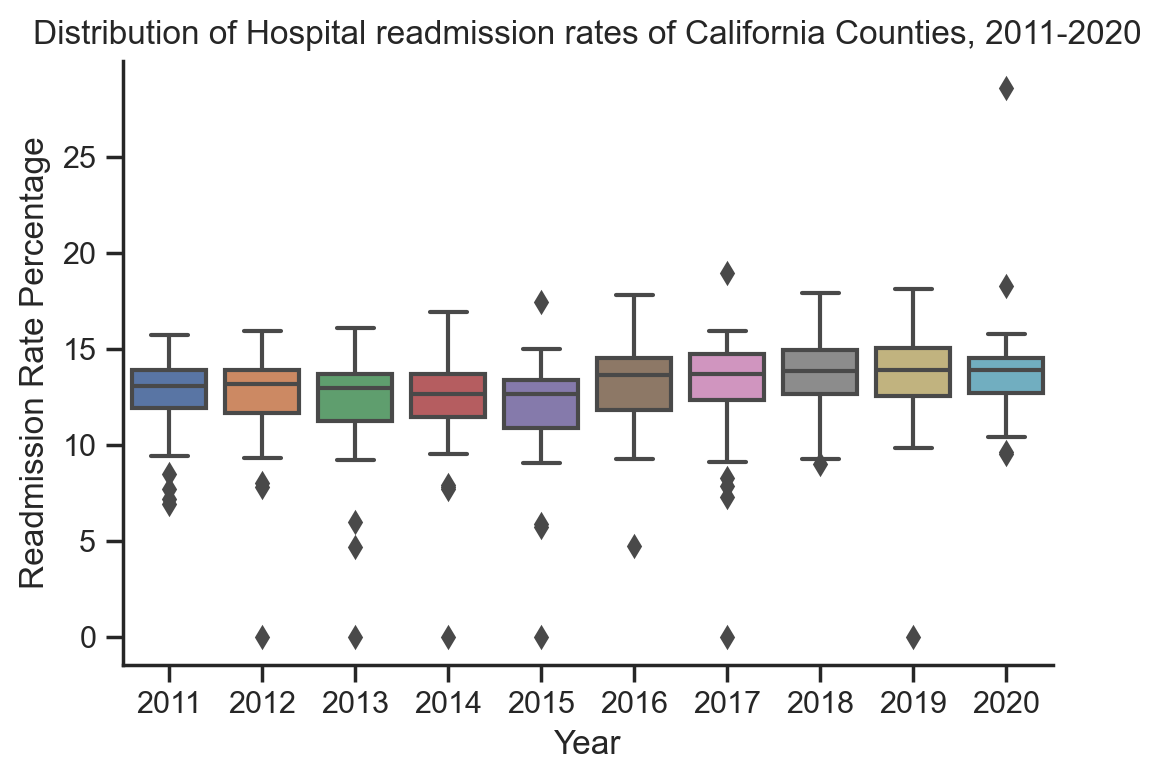

In [391]:
# plot boxplot charts of readmission rates
def boxplot_state_rate(data):
    ax = sns.boxplot(data=data, x="Year", y="Readmission Rate Percentage")
    ax.set(title="Distribution of Hospital readmission rates of California Counties, 2011-2020")
    plt.show()
    
# get readmissions of counties   
df_counties_overall = df_readmission.query("Strata == 'Overall' & County != 'State'")
boxplot_state_rate(df_counties_overall)

There are some readmission rates higher than 25 or lower than 5. Let's check those outliers:

In [636]:
df_counties_overall.query("`Readmission Rate Percentage` > 25 | `Readmission Rate Percentage` < 5")

,Year,Strata,Strata Name,County,Admissions,Readmissions,Readmission Rate Percentage
93,2012,Overall,Overall,Alpine,10,0,0.00
168,2013,Overall,Overall,Alpine,9,0,0.00
180,2013,Overall,Overall,Inyo,722,34,4.70
243,2014,Overall,Overall,Alpine,11,0,0.00
318,2015,Overall,Overall,Alpine,9,0,0.00
393,2016,Overall,Overall,Alpine,21,1,4.76
468,2017,Overall,Overall,Alpine,9,0,0.00
620,2019,Overall,Overall,Alpine,10,0,0.00
696,2020,Overall,Overall,Alpine,7,2,28.57


8/9 of those outliers are from Alpine, which is a small county has a population of 1204 according to 2020 census. Given its population and admissions, it's not representive enough for further investigation in this project. Let's remove it.

In [654]:
# Remove outliers
outlier_filter = "County != 'Alpine'"
df_readmission = df_readmission.query(outlier_filter)
df_ltc = df_ltc.query(outlier_filter)
df_population = df_population.query(outlier_filter)
df_all = df_all.query(outlier_filter)

### 5.2 By Age

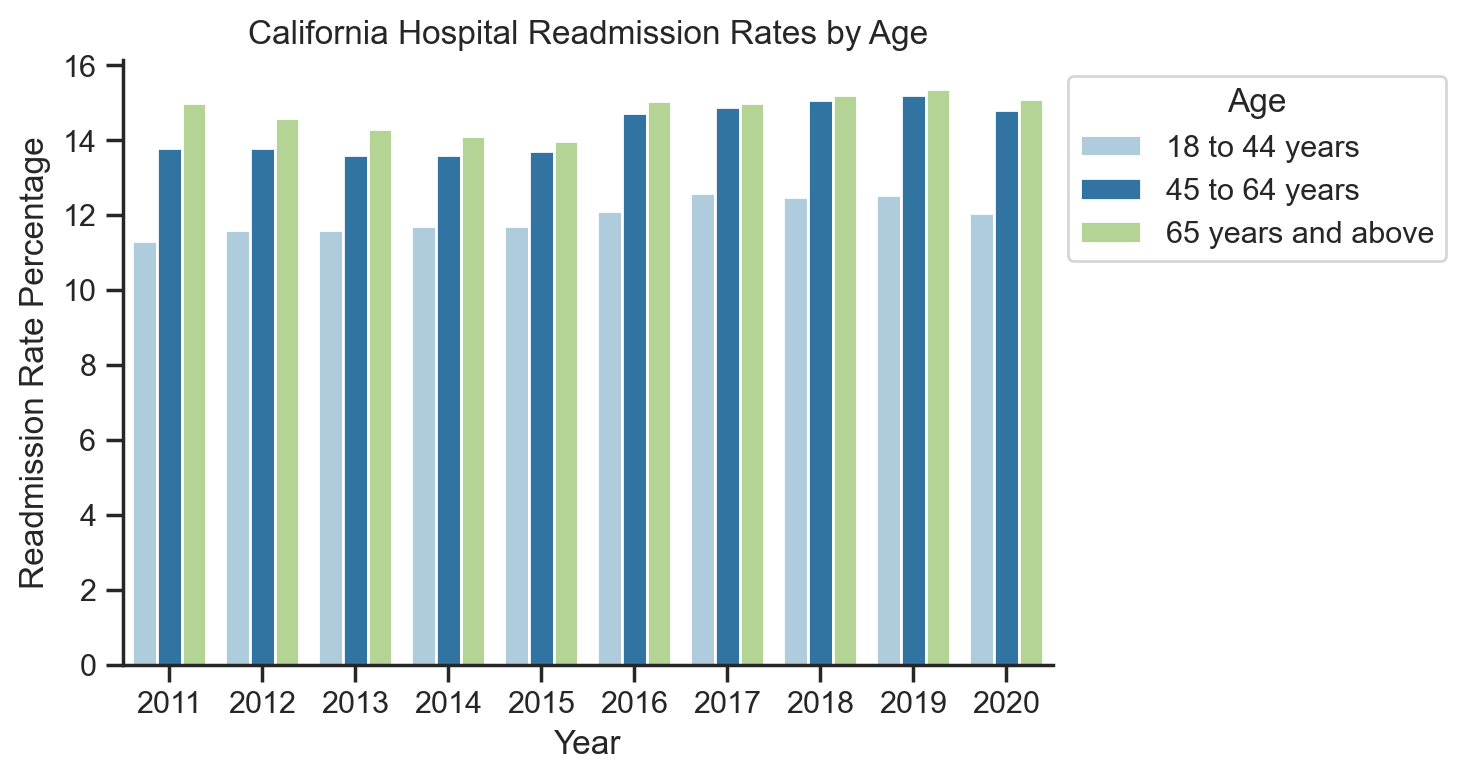

In [398]:
def barplot_state_rate(data, hue, palette="Paired"):
    ax = sns.barplot(data=data, x="Year", y="Readmission Rate Percentage", hue="Strata Name", palette=palette)
    ax.legend(title=hue, bbox_to_anchor=(1, 1))
    ax.set(title=f"California Hospital Readmission Rates by {hue}")
    plt.show()
    
df_state_age = df_readmission.query("Strata == 'Age' & County == 'State'")
barplot_state_rate(df_state_age, hue="Age")

Readmission rates increase with patient age. Healthcare providers need to pay more attention to patients 45 or older, and especially those 65 and older.

### 5.3 By Sex

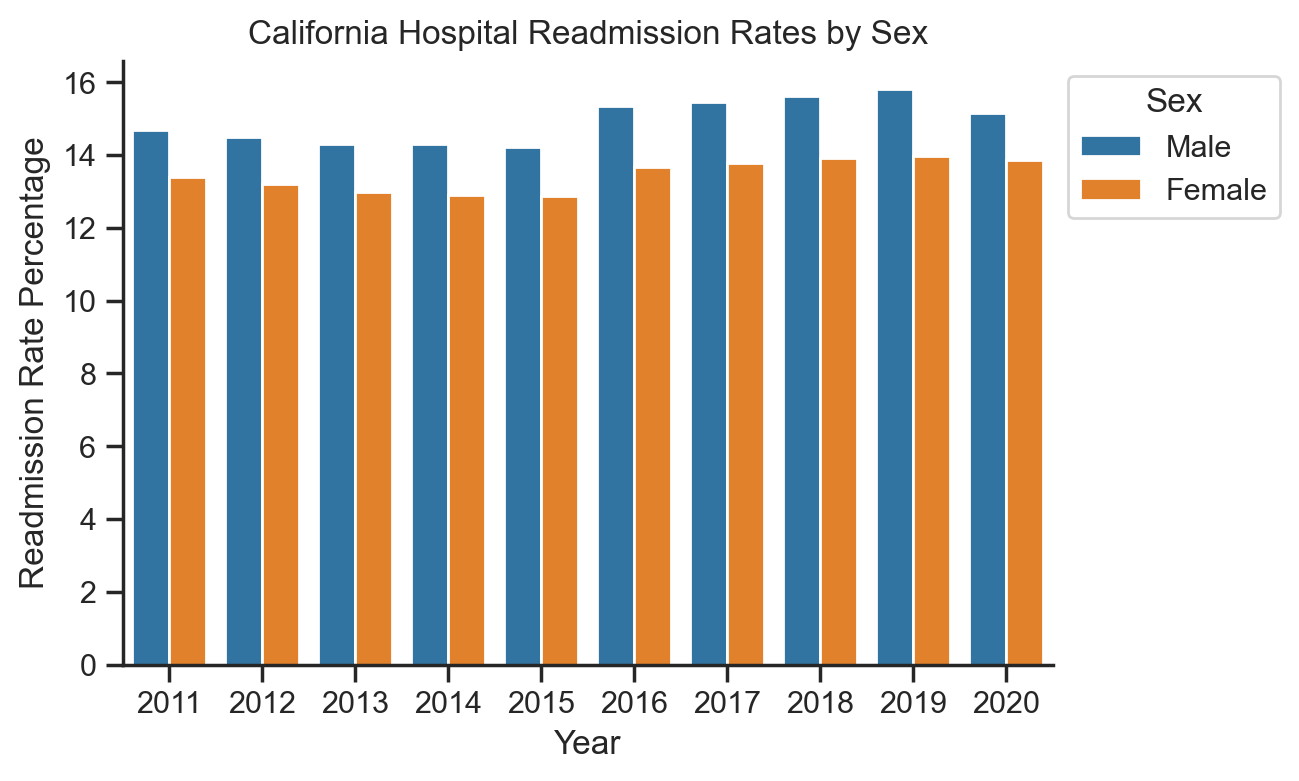

In [399]:
df_state_sex = df_readmission.query("Strata == 'Sex' & County == 'State'")
barplot_state_rate(df_state_sex, hue="Sex", palette="tab10")

In 2011-2020, readmission rates for men had been consistently higher than for women.

### 5.4 By Race-Ethnicity

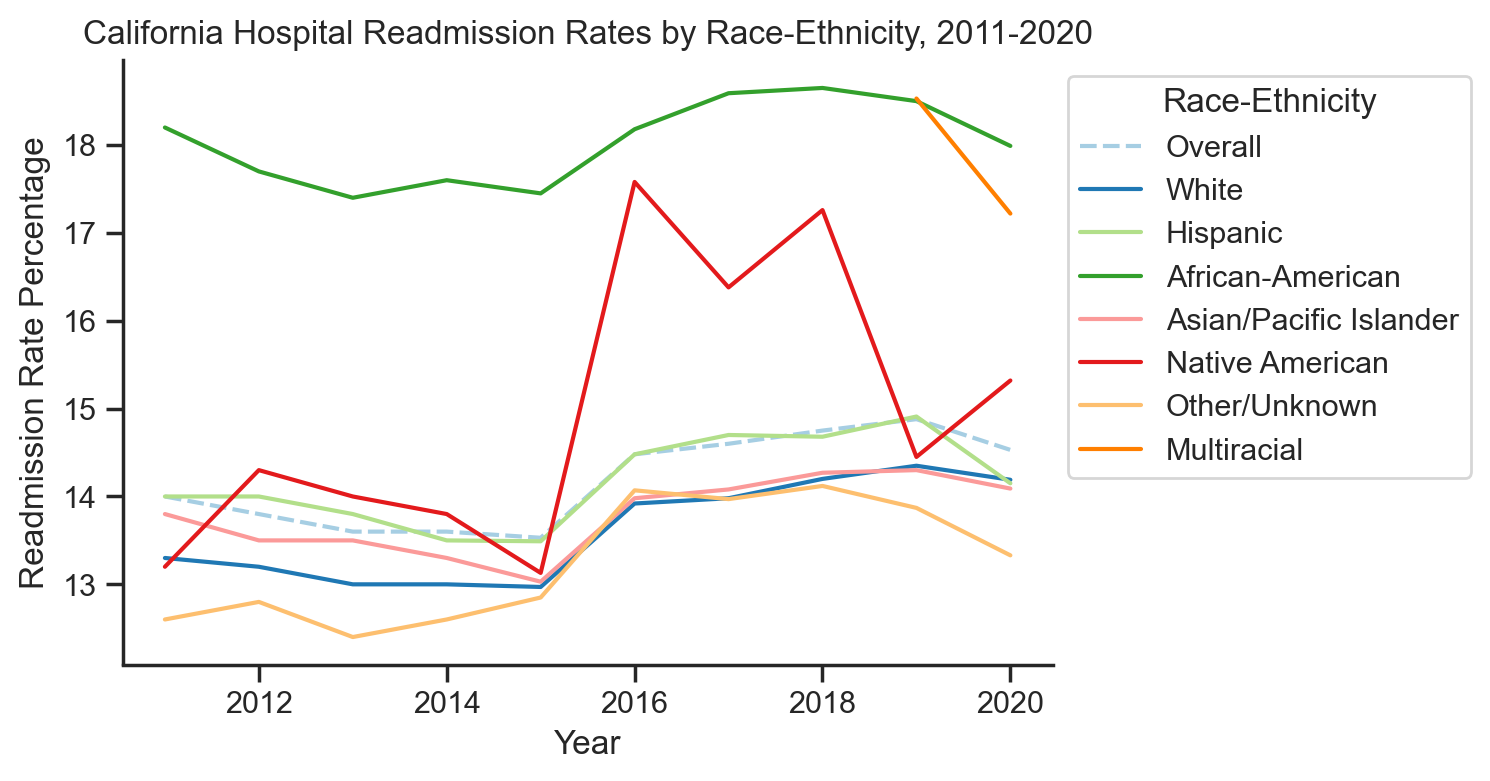

In [641]:
# lineplot readmission rates by demographic category
def plot_rate_by_category(data, legend_title, dash_style, palette="Paired"):
    ax = sns.lineplot(data=data, x="Year", y="Readmission Rate Percentage", 
                      hue="Strata Name", style="Strata Name", 
                      palette=palette, dashes=dash_style)
    ax.legend(title=legend_title, bbox_to_anchor=(1, 1))
    ax.set(title=f"California Hospital Readmission Rates by {legend_title}, 2011-2020")
    plt.show()


# statewide data plus data by race
df_state_overall_race = df_readmission.query("Strata in ['Overall', 'Race-Ethnicity'] & County == 'State'")
# default line style
dash_style = {x: '' for x in df_state_overall_race['Strata Name'].unique()}
# set dashed statewide overall line
dash_style['Overall'] = (4, 1.5)
plot_rate_by_category(df_state_overall_race, legend_title="Race-Ethnicity", dash_style=dash_style)

Disparities between races have persisted and have worsened since 2016. In 2016-2020, the top three readmission rates were African American, multiracial, and Native American. More specifically, African American patients consistently had the highest readmission rates. Multiracial was newly a dded to the dataset in 2019, and it had the second-highest readmission rate. 

The highest increase in readmission rates was from Native American. Before 2016, its readmission rate was very similar to that of other races with low readmission rates, but it rose above 17% in 2016 and 2018 and remains above 15% in 2020.

### 5.5 By Payer

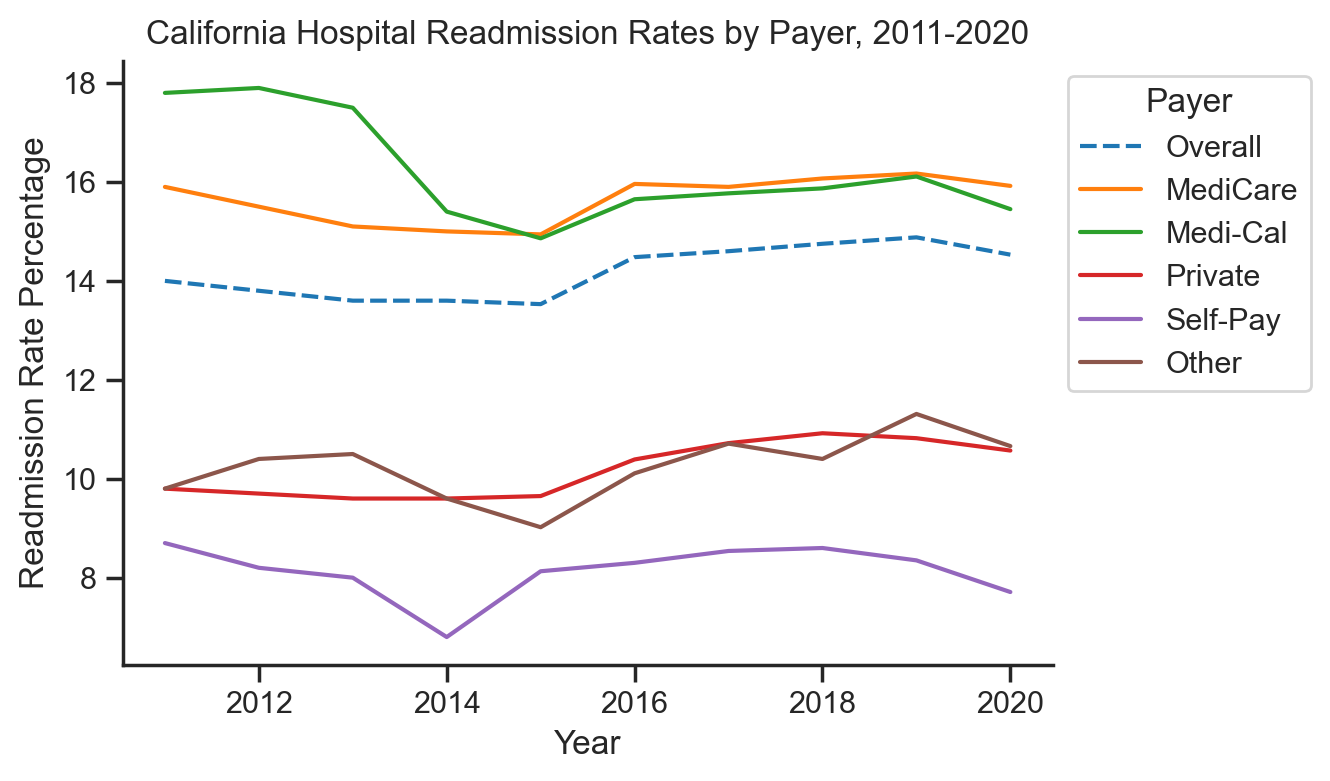

In [642]:
# statewide data plus data by race
df_state_overall_payer = df_readmission.query("Strata in ['Overall', 'Expected Payer'] & County == 'State'")
# default line style
styles = {x: '' for x in df_state_overall_payer['Strata Name'].unique()}
# set dashed statewide overall line
styles['Overall'] = (4, 1.5)
plot_rate_by_category(df_state_overall_payer, legend_title='Payer', dash_style=styles, palette="tab10")

In 2011-2020, patients with MediCare (serves seniors 65 and up and younger people with certain disabilities) and Medi-Cal (serves low-income individuals and families) coverage always have the highest readmission rates. But we can also note that the readmission rate for patients with Medi-Cal has decreased significantly since 2015, due to the increase in adults under age 65 covered by Medi-Cal under the [Affordable Care Act](https://www.dhcs.ca.gov/individuals/Pages/AffordableCareActLinks.aspx).

### 5.6 By County

In [655]:
def add_fips(data, state_name):
    # get FIPS code of counties
    fips = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/minoritymajority.csv', 
                       dtype={'FIPS': str})
    filtered_fips = fips.query(f"STNAME == '{state_name}'")[['FIPS', 'CTYNAME']]
    filtered_fips.rename(columns={'FIPS': 'County_FIPS', 'CTYNAME': 'County'}, inplace=True)
    filtered_fips['County'] = filtered_fips['County'].str.replace(' County', '')
    # add fips to the input dataset
    data = data.merge(filtered_fips, how='left', on='County')
    
    return data

def plot_county_map(data, state_fips_code):
    # load geojson of all counties
    r = requests.get('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json')
    counties = json.loads(r.text)
    # get geojson of specific state
    counties['features'] = [f for f in counties['features'] if f['properties']['STATE'] == state_fips_code]
    # plot map
    fig = px.choropleth(data, geojson=counties, locations='County_FIPS', 
                        color='Readmission Rate Percentage', color_continuous_scale='Sunset', scope='usa', 
                        hover_name="County", hover_data=["Readmission Rate Percentage"],
                        labels={'Readmission Rate Percentage': 'Readmission Rate (%) in 2020'}
                        )
    fig.add_scattergeo(geojson=counties,
                       locations=data['County_FIPS'],
                       text=data['Readmission Rate Percentage'],
                       textfont=dict(family="sans serif", size=8),
                       mode = 'text'
                       )

    fig.update_layout(title_text='California Hospital Readmission Rates by County, 2020')
    fig.update_geos(fitbounds='locations', visible=False)
    fig.show()
    
# add county FIPS code to the combined readmission dataset
df_all = add_fips(df_all, state_name='California')
# get b2020 records
df_2020 = df_all.query("County_FIPS.notna() & Year == 2020")
df_county_2020 = df_2020[['County', 'Readmission Rate Percentage', 'County_FIPS']].drop_duplicates()
# California's FIPS code is "06"
# Ref U.S. Bureau of Labor Statistics Appendix D - USPS State Abbreviations and FIPS Codes
plot_county_map(df_county_2020, state_fips_code='06')


![California Map: Readmission Rates by County](images/ca-county-map.png)

Some counties in the middle or north California had higher readmission rate than others, let's see how their rates change over time.

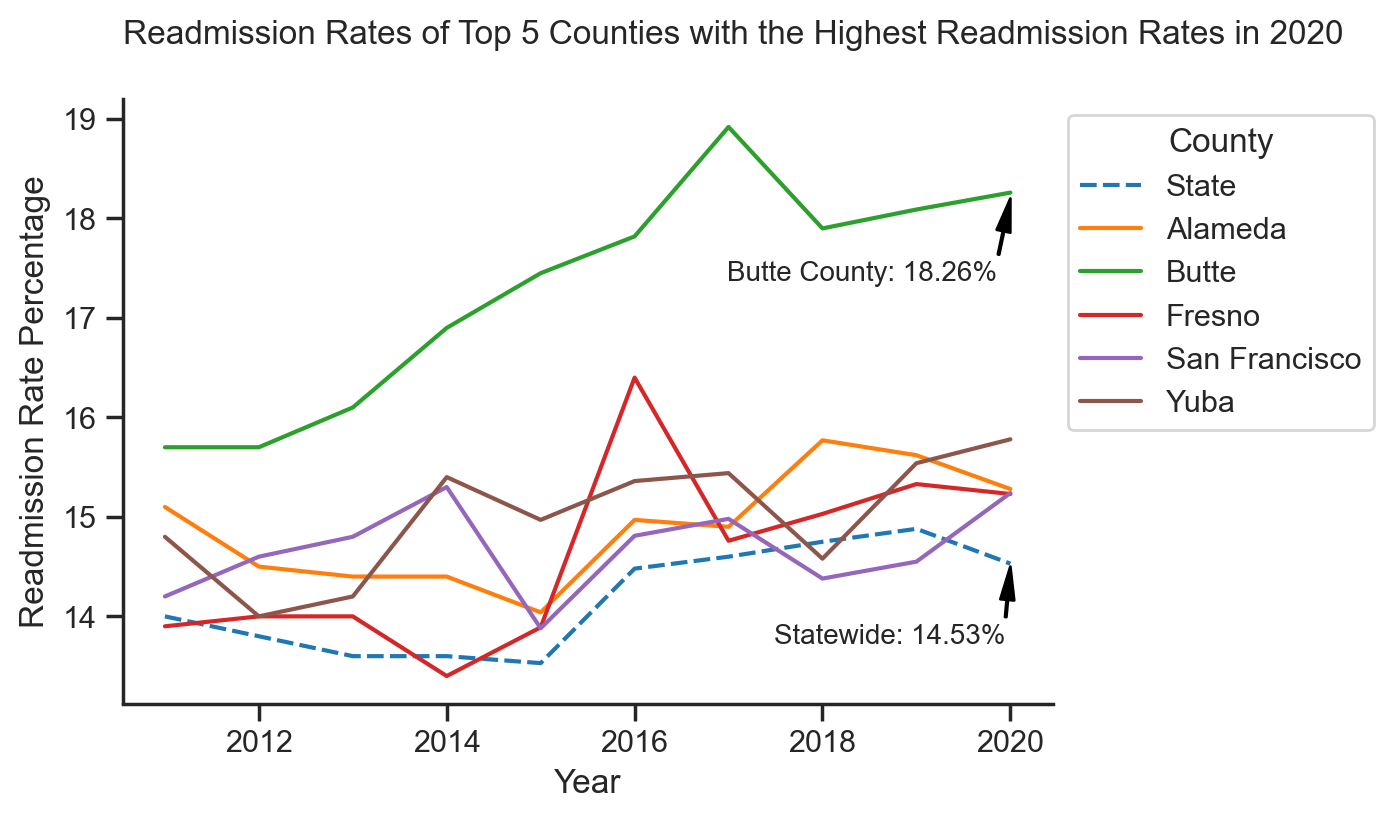

In [537]:
def lineplot_county_rate(data, dash_style):
    ax = sns.lineplot(data=data, x="Year", y="Readmission Rate Percentage", 
                      hue="County", palette="tab10", style="County", dashes=dash_style)   
    ax.annotate('Butte County: 18.26%', 
                xy=(2020, 18.2),
                xycoords='data',
                xytext=(0.65, 0.7), 
                textcoords='axes fraction',
                fontsize=10,
                arrowprops=dict(color='black', width=0.5, headwidth=5))
    ax.annotate('Statewide: 14.53%', 
                xy=(2020, 14.5),
                xycoords='data',
                xytext=(0.7, 0.1), 
                textcoords='axes fraction',
                fontsize=10,
                arrowprops=dict(color='black', width=0.5, headwidth=5))
    ax.legend(title='County', bbox_to_anchor=(1, 1))
    plt.suptitle('Readmission Rates of Top 5 Counties with the Highest Readmission Rates in 2020', x=0.125, y=0.98, ha='left', fontsize=12)
    plt.show()

# get top 5 counties with highest readmission rates in 2020
top_county_data = df_county_2020.sort_values(by=['Readmission Rate Percentage'], ascending=False).head(5)
top_5_counties = top_county_data.head(5)['County'].to_list()

# concatenating statewide and 5 counties data
df_state_payer = df_readmission.query("Strata == 'Expected Payer' & County == 'State'") 
df_county_rate = df_readmission.query(f"Strata == 'Overall' & County in {top_5_counties}")
df_county_state_rate = pd.concat([df_state_overall, df_county_rate], axis=0)

# default line style
dash_style = {x: '' for x in df_county_state_rate['County'].unique()}
# set dashed statewide overall line
dash_style['State'] = (4, 1.5)
lineplot_county_rate(df_county_state_rate, dash_style)

In [627]:
# get each year's highest readmission rates
highest_rates = df_readmission.query("Strata == 'Overall' & County != 'State'").sort_values(by=['Year','Readmission Rate Percentage'], ascending=False)\
.groupby('Year').head(1)
highest_rates

,Year,Strata,Strata Name,County,Admissions,Readmissions,Readmission Rate Percentage
698,2020,Overall,Overall,Butte,19635,3585,18.26
622,2019,Overall,Overall,Butte,21958,3973,18.09
545,2018,Overall,Overall,Butte,23190,4151,17.90
470,2017,Overall,Overall,Butte,23283,4406,18.92
395,2016,Overall,Overall,Butte,22675,4041,17.82
320,2015,Overall,Overall,Butte,16661,2907,17.45
245,2014,Overall,Overall,Butte,21081,3558,16.90
170,2013,Overall,Overall,Butte,21019,3383,16.10
97,2012,Overall,Overall,Colusa,1125,179,15.90
20,2011,Overall,Overall,Butte,20422,3198,15.70


**Butte County** almost consistently had the highest readmission rate in 2011-2020. It's been significantly higher than statewide rate and the other top-ranked counties, and still rising. We will need to gather more data to find the root cause.

### 5.7 By LTC Type Facility Ratio

To find out whether LTC/Non-LTC facility has any effect on readmission rate, we need to create new field `LTC Ratio`/`Non-LTC Ratio` that calculates each county's population divide the number of LTC/Non-LTC facilities.
LTC_Ratio equals 10000 means 1 LTC facility for every 10000 people.

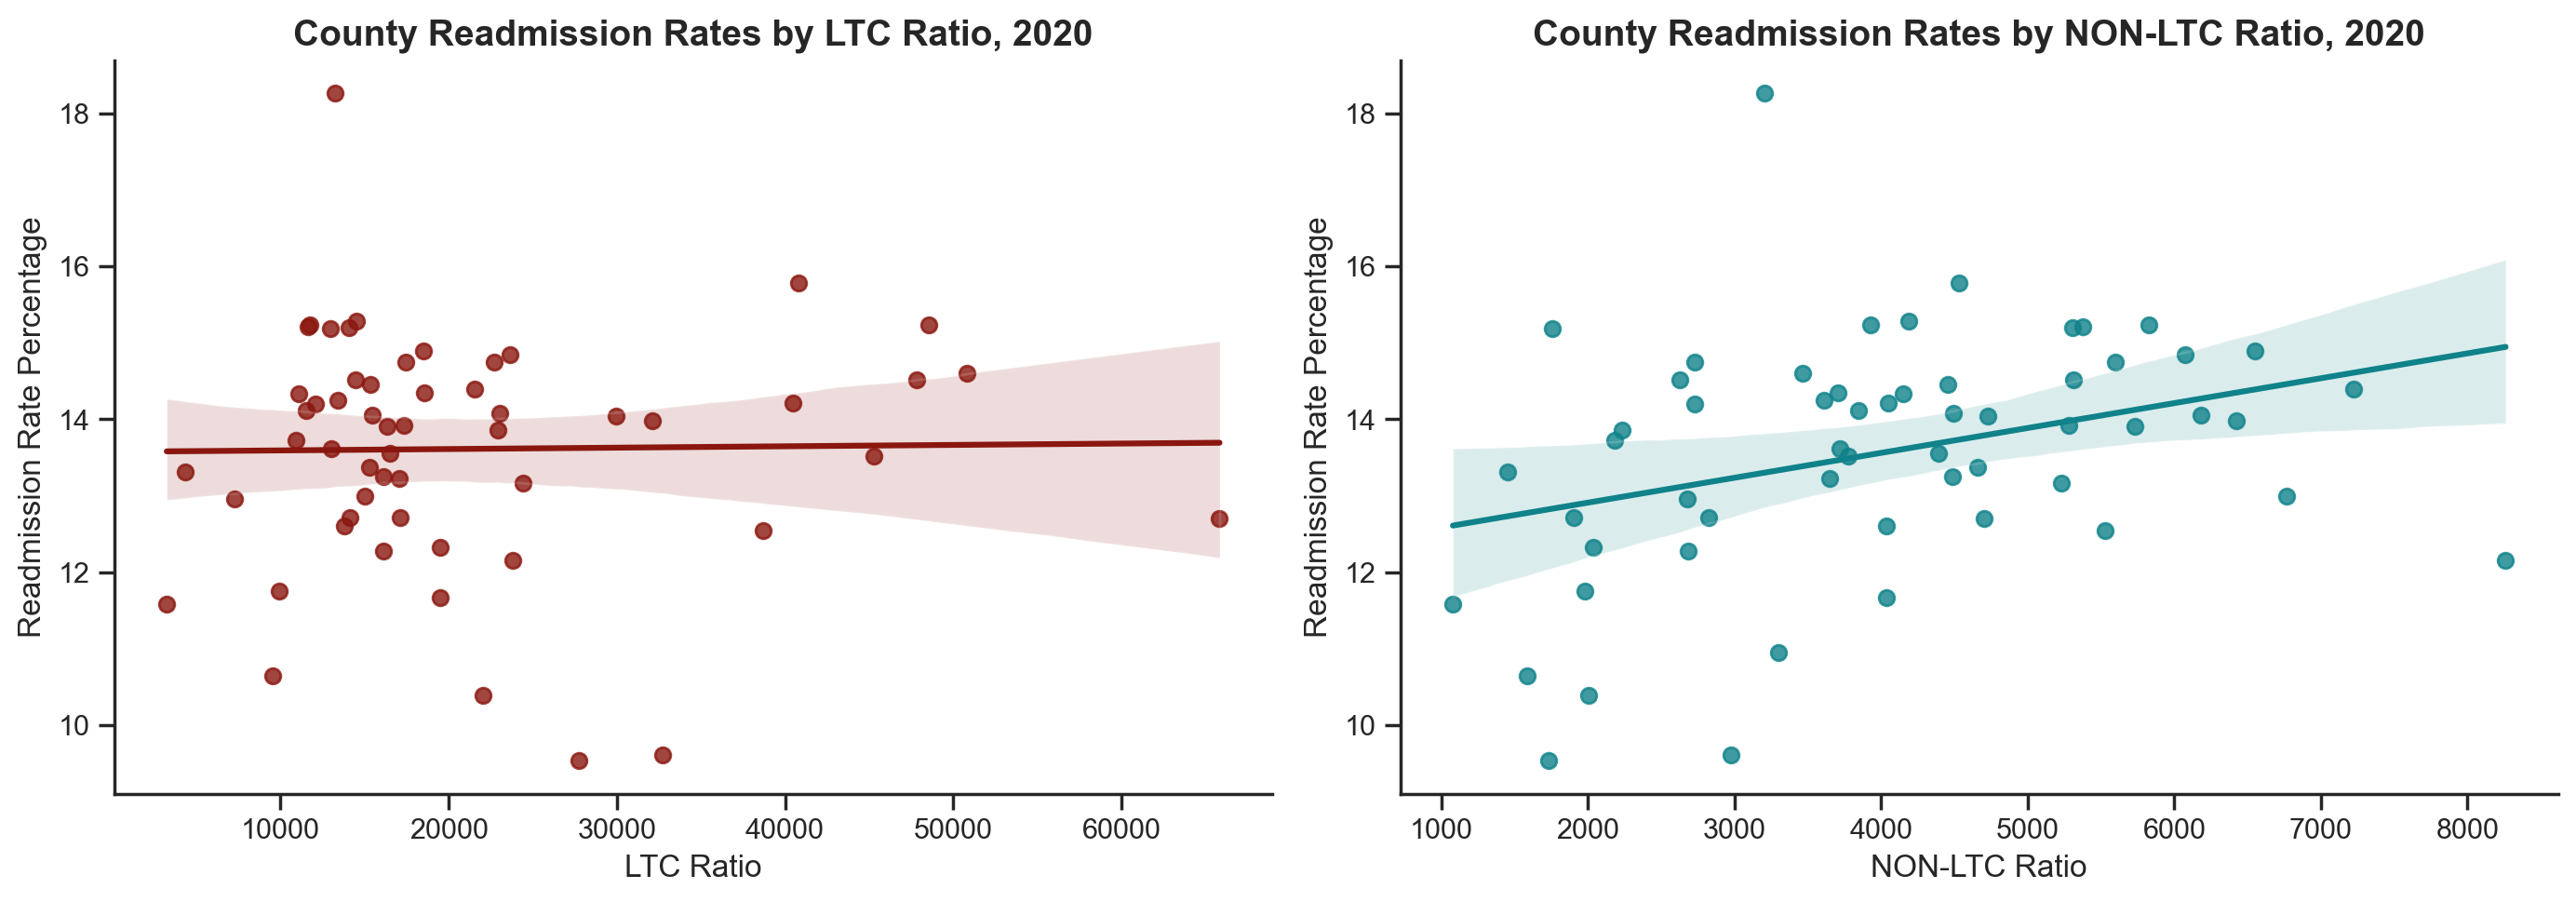

In [592]:
def get_facility_type_ratio(col_fac_type):
    """Method for calculating population-to-facility ratio (population/# of facility)
       of each county
    
    Args:
        col_fac_type: column name of the facility type, 'LTC_Type' or 'FDR_Type'
    Returns:
        a dataframe with county as rows, facility type values as columns,
        population-to-facility ratio as values
    """
    # get count of facilities of each county in 2020
    data_fac_cnt = df_2020.groupby(['County', col_fac_type]).size().unstack(fill_value=0)
    data_fac_cnt.columns += ' Ratio'
    df_readmission_2020 = df_2020[['County', 'Readmission Rate Percentage', 'Population']].drop_duplicates()
    # concat readmission rates with count of facilities
    df_fac_readmission = df_readmission_2020.merge(data_fac_cnt, how='left', on='County')
    # get population-to-facility ratio
    df_ratio = df_fac_readmission.apply(lambda x: round(df_fac_readmission['Population']/x, 2)\
                                 if x.name not in ['County', 'Readmission Rate Percentage', 'Population'] else x)
    df_ratio = df_ratio.replace([np.inf, -np.inf], np.nan)
    
    return df_ratio

def plot_fac_ratio(data, ratio_list):
    """Regplot scatter charts of each facility type ratio vs. readmission rate
    
    Args:
        data: the dataframe contains `ratio_list` and `Readmission Rate Percentage`
        ratio_list: columns of facility type ratio, such as 'LTC Ratio'
    Returns:
        scatter chart with a linear regression model fit of each facility type ratio
    """
    colors = sns.hls_palette(len(ratio_list), l=.3, s=.8).as_hex()
    nrow = int(np.ceil(len(ratio_list)/2))
    ncol = 2
    i = 1
    for fac_ratio in ratio_list:
        plt.subplot(nrow, ncol, int(i))
        plt.gca().set_title(f"County Readmission Rates by {fac_ratio}, 2020",
                    fontsize=14, weight='bold')
        sns.regplot(data=data, x=fac_ratio, y='Readmission Rate Percentage', color=colors[i-1])
        i += 1
    plt.tight_layout()


ratio_list = ['LTC Ratio', 'NON-LTC Ratio']
# get ratio of LTC types
df_ltc_ratio = get_facility_type_ratio('LTC_Type')
plt.figure(figsize=(14, 5))
# plot readmission rates by facility ratio
plot_fac_ratio(df_ltc_ratio, ratio_list)

`LTC Ratio` doesn't have obvious linear relationship with readmission rates, while the readmission rate seems to increase with `Non LTC Ratio`.

Next, let's investigate whether the more granular facility type, the FDR type, has any relationship to readmission rates.

### 5.8 By FDR Type Facility Ratio

First of all, we need to calculate each FDR type's ratio, that is, each county's population divide the number of the specific FDR type.

In [591]:
# get FDR Facility Ratio
df_fdr_ratio = get_facility_type_ratio('FDR_Type')
df_fdr_ratio.head()

,County,Readmission Rate Percentage,Population,Acute Psychiatric Hospital Ratio,Adult Day Health Care Ratio,Alternative Birthing Center Ratio,Chemical Dependency Recovery Hospital Ratio,Chronic Dialysis Clinic Ratio,Congregate Living Health Facility Ratio,Correctional Treatment Center Ratio,General Acute Care Hospital Ratio,Home Health Agency Ratio,Hospice Ratio,Hospice Facility Ratio,Intermediate Care Facility Ratio,Intermediate Care Facility-Dd/H/N/Cn/Iid Ratio,Other Ratio,Pediatric Day Health & Respite Care Facility Ratio,Primary Care Clinic Ratio,Psychology Clinic Ratio,Referral Agency Ratio,Rehabilitation Clinic Ratio,Skilled Nursing Facility Ratio,Surgical Clinic Ratio
0,Alameda,15.28,1682353,420588.25,210294.12,NaN,1682353.0,49480.97,210294.12,NaN,93464.06,18487.40,29514.96,NaN,NaN,48067.23,48067.23,NaN,10580.84,420588.25,NaN,841176.5,23045.93,70098.04
1,Amador,14.21,40474,NaN,NaN,NaN,NaN,NaN,NaN,40474.0,40474.00,20237.00,40474.00,NaN,NaN,NaN,NaN,NaN,10118.50,NaN,NaN,NaN,40474.00,40474.00
2,Butte,18.26,211632,211632.00,211632.00,NaN,NaN,42326.40,NaN,NaN,42326.40,23514.67,105816.00,NaN,NaN,35272.00,105816.00,211632.0,5426.46,NaN,NaN,NaN,23514.67,52908.00
3,Calaveras,13.52,45292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45292.00,45292.00,NaN,NaN,NaN,NaN,NaN,NaN,4529.20,NaN,NaN,NaN,45292.00,NaN
4,Colusa,13.73,21839,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21839.00,21839.00,21839.00,NaN,NaN,NaN,NaN,NaN,3119.86,NaN,NaN,NaN,10919.50,NaN


As we can see from above, unlike `LTC_Type` with 3 unique facility types only, there are a lot more types in `FDR_Type`. Certain FDR types only exist in a few counties and thus are too rare to have a significant impact.

To get a meaningful result, let's focus on the FDR types that exist at least 20 counties.

In [548]:
exclude_cols = ['County', 'Readmission Rate Percentage', 'Population']
# count not null rows of each FDR type
fdr_notnull = df_fdr_ratio.loc[:, ~df_fdr_ratio.columns.isin(exclude_cols)].notnull().sum()\
              .rename_axis('var').reset_index(name='count')
# get FDR types that exist in at least 20 counties 
fdr_selected = fdr_notnull.query("count >= 20")["var"].to_list()
fdr_selected

['Acute Psychiatric Hospital Ratio',
 'Adult Day Health Care Ratio',
 'Chronic Dialysis Clinic Ratio',
 'Congregate Living Health Facility Ratio',
 'General Acute Care Hospital Ratio',
 'Home Health Agency Ratio',
 'Hospice Ratio',
 'Intermediate Care Facility-Dd/H/N/Cn/Iid Ratio',
 'Other Ratio',
 'Primary Care Clinic Ratio',
 'Rehabilitation Clinic Ratio',
 'Skilled Nursing Facility Ratio',
 'Surgical Clinic Ratio']

There are 13 FDR types that exist in at least 20 counties in 2020, let's plot their scatter charts with readmission rates.

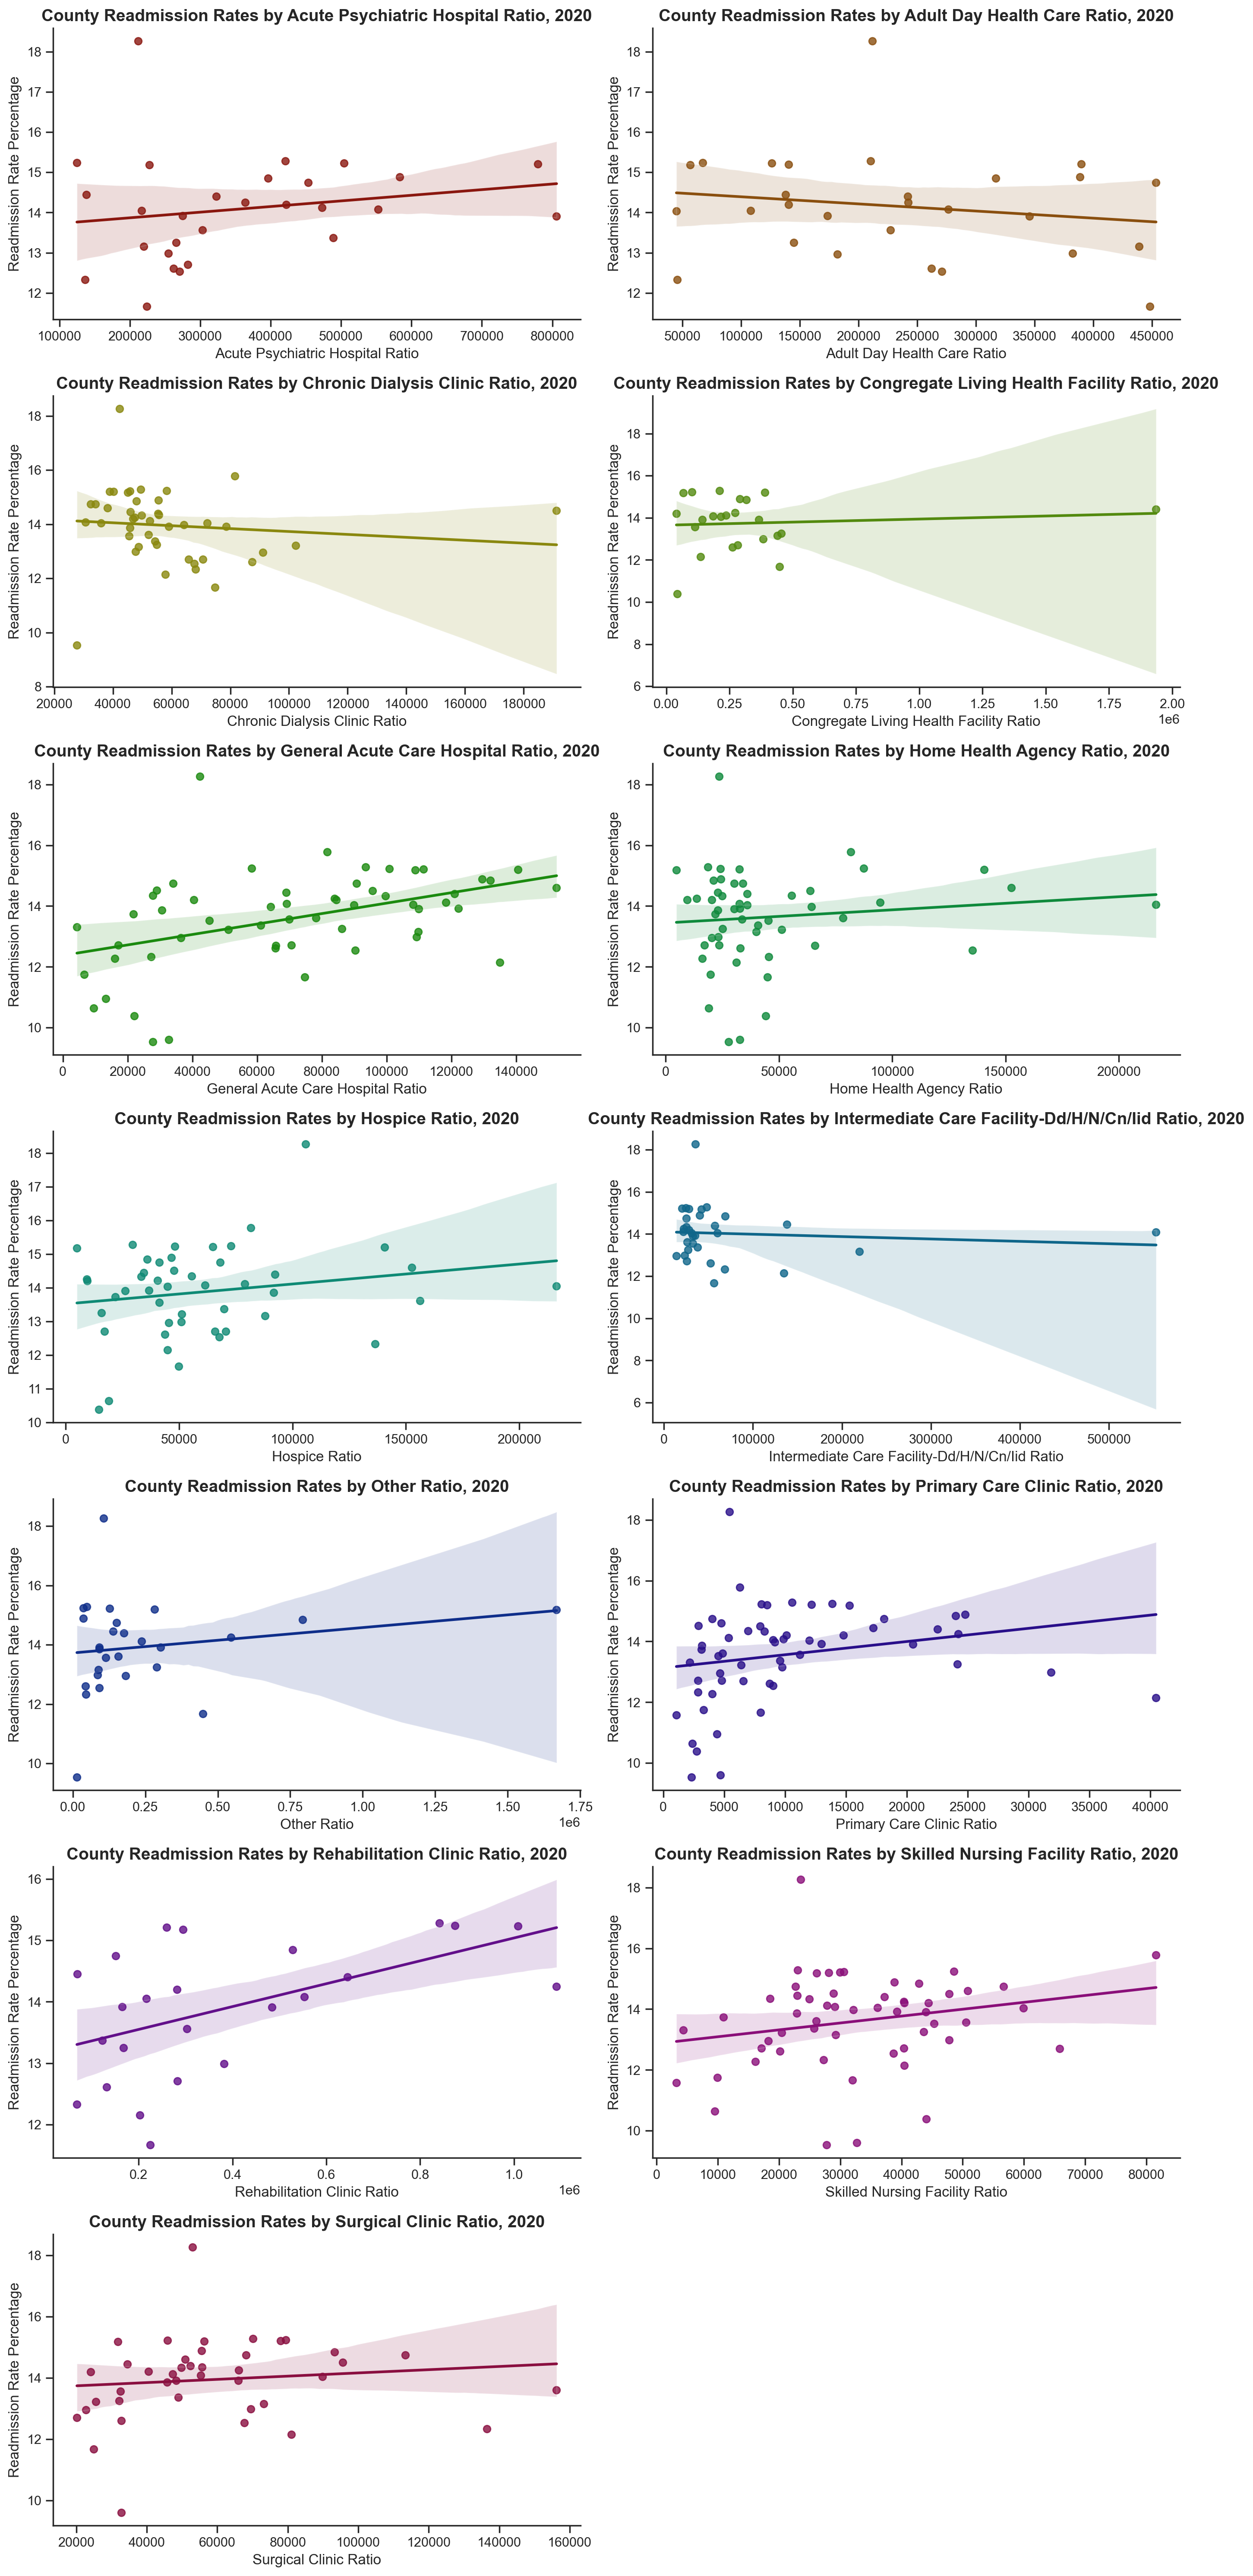

In [593]:
# plot readmission rates by selected FDR types
plt.figure(figsize=(14, 30))
plot_fac_ratio(df_fdr_ratio, fdr_selected)

Readmission rates are slightly proportional to ratios for several FDR types, such as General Acute Care Hospital Ratio and Rehabilitation Clinic Ratio.

To get more accurate result, we can compute their Pearson correlation coefficients and p-values. 

### 5.9 Coefficient of Correlation

In [575]:
def pearsonr_readmission(data, col_list):
    """Method for calculating Pearson correlation coefficient and p-value
       between `col_list` and `Readmission Rate Percentage`
    
    Args:
        data: the dataset with `col_list` and Readmission Rate Percentage
        col_list: the list of column names
    Returns:
        a dataframe with correlation coefficients and p-values and is sorted by
        p-value ascending
    """
    correlations = []
    pvalues = []
    for col in col_list:
        df_tmp = data[[col, 'Readmission Rate Percentage']].dropna()
        r, p = stats.pearsonr(df_tmp[col], df_tmp['Readmission Rate Percentage'])
        correlations.append(r)
        pvalues.append(p)
    corrs = pd.DataFrame({'Field': col_list, 
                          'Correlation Coefficient': correlations,
                          'p-value': pvalues})
    corrs.sort_values(by=['p-value'], inplace=True)
    return corrs
  
# get Pearson R between selected FDR Types and Readmission Rate
df_corr = pearsonr_readmission(df_fdr_ratio, fdr_selected)
df_corr

,Field,Correlation Coefficient,p-value
4,General Acute Care Hospital Ratio,0.438389,0.000726
10,Rehabilitation Clinic Ratio,0.522389,0.008826
9,Primary Care Clinic Ratio,0.225205,0.092123
11,Skilled Nursing Facility Ratio,0.222746,0.098926
6,Hospice Ratio,0.189469,0.202117
0,Acute Psychiatric Hospital Ratio,0.191272,0.329554
8,Other Ratio,0.183081,0.360686
1,Adult Day Health Care Ratio,-0.173474,0.377339
5,Home Health Agency Ratio,0.110626,0.430352
12,Surgical Clinic Ratio,0.116698,0.467463


In general, a meaningful correlation must have correlation coefficients >= 0.25 and p-value <= 0.05. Thus **General Acute Care Hospital Ratio** and **Rehabilitation Clinic Ratio** are the only 2 FDR types that have positive correlations with readmission rates.

Let's create a heatmap to visualize the correlations.

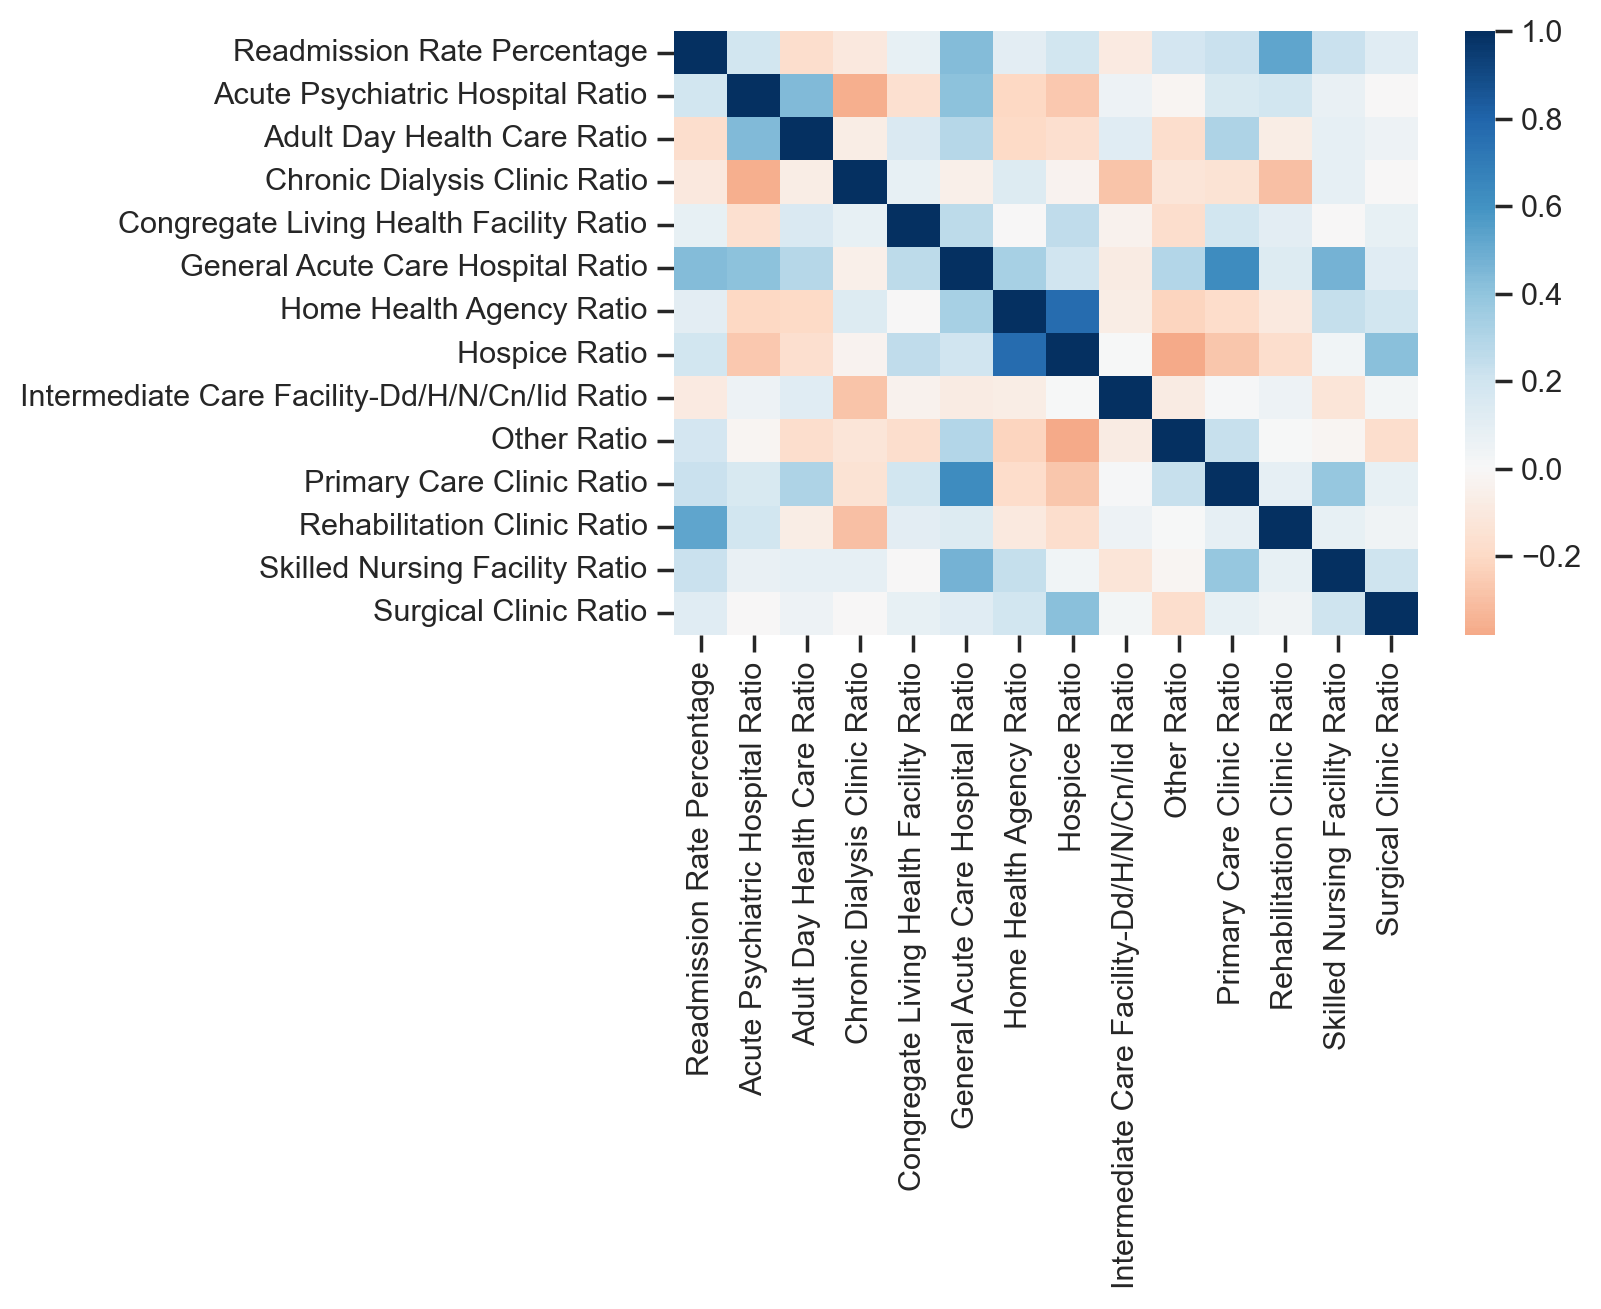

In [576]:
readmission_cor = df_fdr_ratio[['Readmission Rate Percentage'] + fdr_selected].corr()
sns.heatmap(readmission_cor, xticklabels=1, yticklabels=1, center=0, cmap="RdBu")
plt.show()

The heatmap also indicates that **General Acute Care Hospital Ratio** and **Rehabilitation Clinic Ratio** are positively correlated with readmission rate. How do we interpret that?

Large General Acute Care Hospital Ratio means more people share a General Acute Care Hospital facility, which means resources and hospital staffing are more scarce. As a result, patients may not receive high quality healthcare serives in the hospital and are more likely to be readmitted.

Rehabilitation clinics provide follow-up care for patients after discharge. Large Rehabilitation Clinic Ratio means that more patients share a Rehabilitation Clinic and therefore may not receive adequate or timely rehabilitation services to restore or improve daily function. As a result, they are more likely to be readmitted.

## 6. Conclusion and Recommendation

We've analyzed statewide and county readmission rates in California. Although more granular data, such as hospital-level or patient-level readmission rates, would be more helpful in drawing firmer conclusions, we did find some patterns in hospital readmission rates in California:

- Age Disparities: Elderly patients **65 and older** had the highest readmission rates.
- Sex Disparities: **Male** patients had higher readmission rates than Female patients.
- Race-Ethnicity Disparities: Readmission rates were highest among **African American** patients, followed by **Native American** patients.
- Payer Disparities: Patients with **Medicare** and **Medi-Cal** had the highest readmission rates and were very close together.
- County Disparities: **Butte County** consistently had the highest readmission rates.
- FDR Facility Ratio Disparities: Counties with larger population to **General Acute Care Hospital** Ratio or population to **Rehabilitation Clinic** Ratio have higher readmission rates.

**Recommendation**:
- Pay more attention to patients groups with have higher readmission rates, provide early discharge planning and follow-up instructions.
- Add more General Acute Care Hospitals in areas with high readmission rates and scarce hospital resources, and cooperate with nearby hospitals with abundant resources.
- Add more Rehabilitation Clinics, or provide assistance for patients to connect to those clinics.